In [1]:
# NLI(Natural Language Interference:자연어 추론) 훈련 예제
#
# => input_ids : [CLS]senetence1(전제)[SEP]sentence2(가설)
# => attention_mask : 1111111111(전체,가설)0000000(그외)
# => token_type_ids : 0000000(전제)1111111(가설)00000000(그외)
# => laels : 참(수반:entailment), 거짓(모순:contradiction), 모름(중립:neutral)

import numpy as np
import pandas as pd
import torch
import os
import torch.nn.functional as F

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, BertForSequenceClassification
import sys
sys.path.append("../../")
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm

logger = mlogging(loggername="distilbertfttrain", logfilename="../../../log/distilbertftmultitrain")
device = GPU_info()
# Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


logfilepath:../../../log/distilbertftmultitrain_2022-10-27.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [2]:
#############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

##################################################
# 변수 설정
##################################################
seed = 111
epochs = 3            # epochs
lr = 3e-5  # 학습률
eps = 1e-8
max_seq_len = 72     # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
train_batch_size = 32      # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)
eval_batch_size = 64
##################################################

seed_everything(seed) # seed 설정

cache = True   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)

use_kornli = 1     #  kornli 파일
use_kluenli = 1    # kluests_v1.1 파일
use_gluenli = 1    # glue 파일

kor_train_file_fpath = '../../../data11/korpora/kornli/snli_1.0_train.ko.tsv'
kor_eval_file_fpath = '../../../data11/korpora/kornli/xnli.dev.ko.tsv'

klue_train_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_train.json'
klue_eval_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_dev.json'

glue_train_file_fpath = '../../../data11/korpora/gluemnli/glue-mnli-train.tsv'
glue_eval_file_fpath = '../../../data11/korpora/gluemnli/glue-mnli-valid.tsv'


# model 타입 : 0=distilbert, 1=bert, 2=Roberta
#=>Roberta 모델에는 distilbert처럼 token_type_id 입력 없음.
model_type = 1
model_path = 'jinmang2/kpfbert' #  #distilbert-base-multilingual-cased #bert-re-kowiki-bert-mecab 
vocab_path = 'jinmang2/kpfbert'
OUTPATH = '../../../data11/model/NLI/kpfbert-nli'

# tokeniaer 및 model 설정
# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
tokenizer = AutoTokenizer.from_pretrained(vocab_path, strip_accents=False, do_lower_case=False) 
                        
# NLI 모델에서 레벨은 3개지(참,거짓,모름) 이므로, num_labels=3을 입력함

if model_type == 0:
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=3)
elif model_type == 1:
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

# 레벨을 멀티로 선택해야 하는 경우
#model = BertForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification",num_labels=6)
                   
#기존 모델 파일을 로딩하는 경우    
#model = torch.load(model_path) 

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36440, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [3]:
model.num_parameters()

114029571

In [4]:
# 학습 data loader 생성
sys.path.append('..')
from myutils import ClassificationDataset, KorNLICorpus, KlueNLICorpus, GlueMNLICorpus, data_collator
from torch.utils.data import DataLoader, RandomSampler

train_dataset = []

# 훈련 NLI dataset 생성
if use_kornli == 1:
    corpus = KorNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=kor_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

if use_kluenli == 1:
    corpus = KlueNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=klue_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    
if use_gluenli == 1:
    corpus = GlueMNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=glue_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    

# 훈련 dataloader 생성
train_loader = DataLoader(train_dataset, 
                          batch_size=train_batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성
eval_dataset = []

if use_kornli == 1:
    corpus = KorNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=kor_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

if use_kluenli == 1:
    corpus = KlueNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=klue_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    
if use_gluenli == 1:
    corpus = GlueMNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=glue_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

# 평가 dataloader 생성

    
eval_loader = DataLoader(eval_dataset, 
                          batch_size=eval_batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

print('train_loader_len: {}, eval_loader_len: {}'.format(len(train_loader), len(eval_loader)))

Loading features from cached file ../../../data11/korpora/kornli/cached_BertTokenizerFast_72_snli_1.0_train.ko.tsv [took %.3f s] 14.711094617843628
Loading features from cached file ../../../data11/korpora/klue-nli/cached_BertTokenizerFast_72_klue-nli-v1.1_train.json [took %.3f s] 0.5000684261322021
Loading features from cached file ../../../data11/korpora/gluemnli/cached_BertTokenizerFast_72_glue-mnli-train.tsv [took %.3f s] 12.976846933364868
Loading features from cached file ../../../data11/korpora/kornli/cached_BertTokenizerFast_72_xnli.dev.ko.tsv [took %.3f s] 0.05015277862548828
Loading features from cached file ../../../data11/korpora/klue-nli/cached_BertTokenizerFast_72_klue-nli-v1.1_dev.json [took %.3f s] 0.05783700942993164
Loading features from cached file ../../../data11/korpora/gluemnli/cached_BertTokenizerFast_72_glue-mnli-valid.tsv [took %.3f s] 0.20394062995910645
train_loader_len: 30246, eval_loader_len: 240


In [5]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다", "정말 재미있다"))
print(tokenizer.convert_ids_to_tokens(131027))
print(tokenizer.convert_tokens_to_ids('정말'))

36440
[2, 2856, 4524, 6993, 4753, 12512, 4534, 4884, 6890, 6947, 4610, 4327, 4673, 4853, 4769, 9632, 4760, 3583, 6005, 4577, 3, 7186, 9421, 4577, 3]
None
7186


In [6]:
import time

logger.info(f"=== model: {model_path} ===")
logger.info(f"num_parameters: {model.num_parameters()}")

# 학습 시작

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=lr, 
                 eps=eps) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

num_warmup_steps = total_steps * 0.1
p_itr = int(total_steps * 0.1)           # 손실률 보여줄 step 수

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        if model_type == 0:
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            labels=labels)
        else:
            outputs = model(input_ids=input_ids, 
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 정확도와 총 손실률 계산
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break
   
    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    # 평가 시작
    
    start = time.time()
    logger.info(f'---------------------------------------------------------')

    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
 
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
              # 모델 실행
            if model_type == 0:
                outputs = model(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                labels=labels)
            else:
                outputs = model(input_ids=input_ids, 
                                token_type_ids=token_type_ids,
                                attention_mask=attention_mask,
                                labels=labels)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            #loss = outputs.loss
            logits = outputs.logits
    
            # 총 손실류 구함
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_test_correct += correct.sum().item()
            total_test_len += len(labels)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    logger.info(f'---------------------------------------------------------')
    logger.info(f'=== 처리시간: {time.time() - start:.3f} 초 ===')
    logger.info(f'-END-\n')
    ####################################################################
    

2022-10-27 10:31:52,019 - distilbertfttrain - INFO - === model: jinmang2/kpfbert ===
2022-10-27 10:31:52,022 - distilbertfttrain - INFO - num_parameters: 114029571
/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30246 [00:00<?, ?it/s]

/tmp/ipykernel_242951/3150600645.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-10-27 10:47:56,915 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 9073 -> Train Loss: 0.7074, Train Accuracy: 0.686
2022-10-27 11:02:53,176 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 18146 -> Train Loss: 0.5804, Train Accuracy: 0.762
2022-10-27 11:20:45,832 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 27219 -> Train Loss: 0.5406, Train Accuracy: 0.780
2022-10-27 11:26:31,924 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

/tmp/ipykernel_242951/3150600645.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-10-27 11:26:52,326 - distilbertfttrain - INFO - [Epoch 1/3] Validatation Accuracy:0.7498856582816074
2022-10-27 11:26:52,328 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-27 11:26:52,329 - distilbertfttrain - INFO - === 처리시간: 20.405 초 ===
2022-10-27 11:26:52,330 - distilbertfttrain - INFO - -END-



  0%|          | 0/30246 [00:00<?, ?it/s]

2022-10-27 11:48:54,062 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 36292 -> Train Loss: 0.4844, Train Accuracy: 0.807
2022-10-27 12:23:06,333 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 45365 -> Train Loss: 0.4610, Train Accuracy: 0.818
2022-10-27 12:57:13,294 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 54438 -> Train Loss: 0.4510, Train Accuracy: 0.821
2022-10-27 13:20:01,056 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

2022-10-27 13:20:31,843 - distilbertfttrain - INFO - [Epoch 2/3] Validatation Accuracy:0.764717412610258
2022-10-27 13:20:31,846 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-27 13:20:31,847 - distilbertfttrain - INFO - === 처리시간: 30.791 초 ===
2022-10-27 13:20:31,848 - distilbertfttrain - INFO - -END-



  0%|          | 0/30246 [00:00<?, ?it/s]

2022-10-27 13:31:52,283 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 63511 -> Train Loss: 0.4206, Train Accuracy: 0.835
2022-10-27 14:06:00,971 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 72584 -> Train Loss: 0.3720, Train Accuracy: 0.857
2022-10-27 14:40:13,142 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 81657 -> Train Loss: 0.3659, Train Accuracy: 0.859
2022-10-27 15:14:22,581 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 90730 -> Train Loss: 0.3599, Train Accuracy: 0.861
2022-10-27 15:14:24,630 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

2022-10-27 15:14:49,994 - distilbertfttrain - INFO - [Epoch 3/3] Validatation Accuracy:0.7776543613198301
2022-10-27 15:14:49,996 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-27 15:14:49,997 - distilbertfttrain - INFO - === 처리시간: 25.367 초 ===
2022-10-27 15:14:49,998 - distilbertfttrain - INFO - -END-



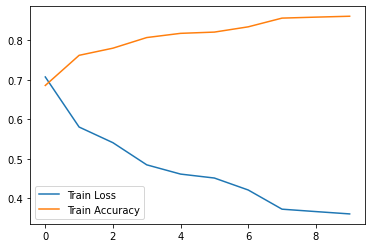

In [7]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

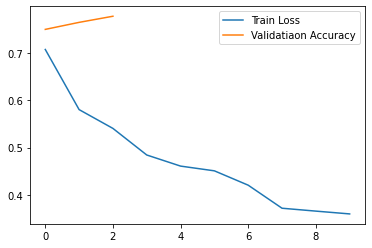

In [8]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [9]:
### 전체모델 저장
#OUTPATH = '../model/distilbert/distilbert-model-0317-distillation-best-nli'

os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH, exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('../../../data11/model/NLI/kpfbert-nli/tokenizer_config.json',
 '../../../data11/model/NLI/kpfbert-nli/special_tokens_map.json',
 '../../../data11/model/NLI/kpfbert-nli/vocab.txt',
 '../../../data11/model/NLI/kpfbert-nli/added_tokens.json',
 '../../../data11/model/NLI/kpfbert-nli/tokenizer.json')